In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
from model import Activity, Dictionary, SparseModel, sparsity_loss, dictionary_loss
import torch

In [2]:
train = pd.read_csv('digit-recognizer/train.csv')
test = pd.read_csv('digit-recognizer/test.csv')

In [3]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
y, X = train['label'], train.loc[:, train.columns != 'label'] / 255

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [6]:
X_train, X_test = X_train.values, X_test.values

In [7]:
X_train = X_train.reshape([X_train.shape[0], 28*28])
X_test = X_test.reshape([X_test.shape[0], 28*28])

In [15]:
batch_size = 1680
epsilon = 1e-6
num_filters = 100
patches_per_img = 4
data_size = X_train.shape[0]
num_batches = data_size // batch_size
alpha = 0.01 #learning rate
sparsity_coef = 0.1 # sparsity coef
beta = .99 #The amount to retain for A and B
img_size = 28
dict_filter_size = img_size**2 //patches_per_img
activity_epochs = 300
epochs=10
num_layers=1

In [16]:
X_train = X_train.reshape([-1, dict_filter_size])
X_test = X_test.reshape([-1, dict_filter_size])

In [17]:
sparse_activity = Activity(batch_size=batch_size, units=num_filters, alpha=alpha, sparsity_coef=sparsity_coef)
sparse_dictionary = Dictionary(units=num_filters, dict_filter_size=dict_filter_size, beta=beta)
sparse_model = SparseModel(sparse_activity, sparse_dictionary, batch_size=batch_size, activity_epochs=activity_epochs, dict_filter_size=dict_filter_size, data_size=data_size, num_layers=num_layers)
sparse_model.compile(sparsity_loss, dictionary_loss)

In [18]:
sparse_model.fit(X_train, epochs=epochs, batch_size=batch_size)

epoch: 0/10 dictionary loss: 301.5998 sparsity loss: 0.0014 : : 67it [00:21,  3.08it/s]
epoch: 1/10 dictionary loss: 0.1382 sparsity loss: 0.0008 : : 67it [00:22,  2.92it/s]
epoch: 2/10 dictionary loss: 0.0696 sparsity loss: 0.0008 : : 67it [00:21,  3.07it/s]
epoch: 3/10 dictionary loss: 0.0615 sparsity loss: 0.0008 : : 67it [00:22,  2.99it/s]
epoch: 4/10 dictionary loss: 0.0628 sparsity loss: 0.0008 : : 67it [00:22,  3.02it/s]
epoch: 5/10 dictionary loss: 0.0958 sparsity loss: 0.0008 : : 67it [00:22,  2.97it/s]
epoch: 6/10 dictionary loss: 0.4114 sparsity loss: 0.0008 : : 67it [00:22,  3.01it/s]
epoch: 7/10 dictionary loss: 1.4838 sparsity loss: 0.0007 : : 67it [00:21,  3.09it/s]
epoch: 8/10 dictionary loss: 2.1362 sparsity loss: 0.0006 : : 67it [00:21,  3.08it/s]
epoch: 9/10 dictionary loss: 2.4864 sparsity loss: 0.0006 : : 67it [00:21,  3.11it/s]


# Filters

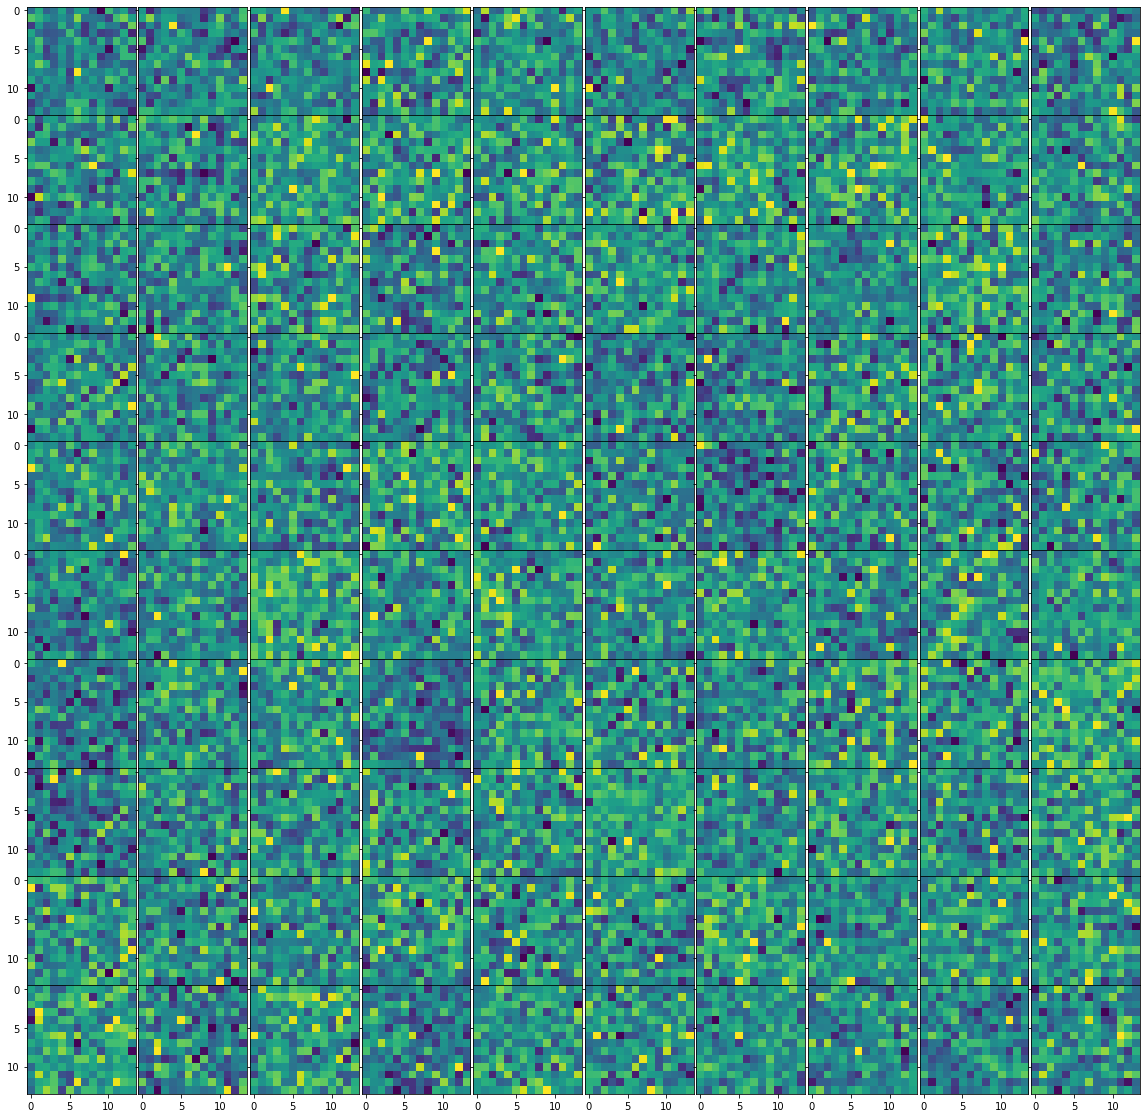

In [19]:
fig = plt.figure(figsize=(20, 20))
num_cols = 10
gs = fig.add_gridspec(num_filters //num_cols, num_cols, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_filters):
    axs[i // num_cols][i % num_cols].imshow(sparse_model.dictionary.w[:, i].reshape([14, 14]).cpu())
plt.show()

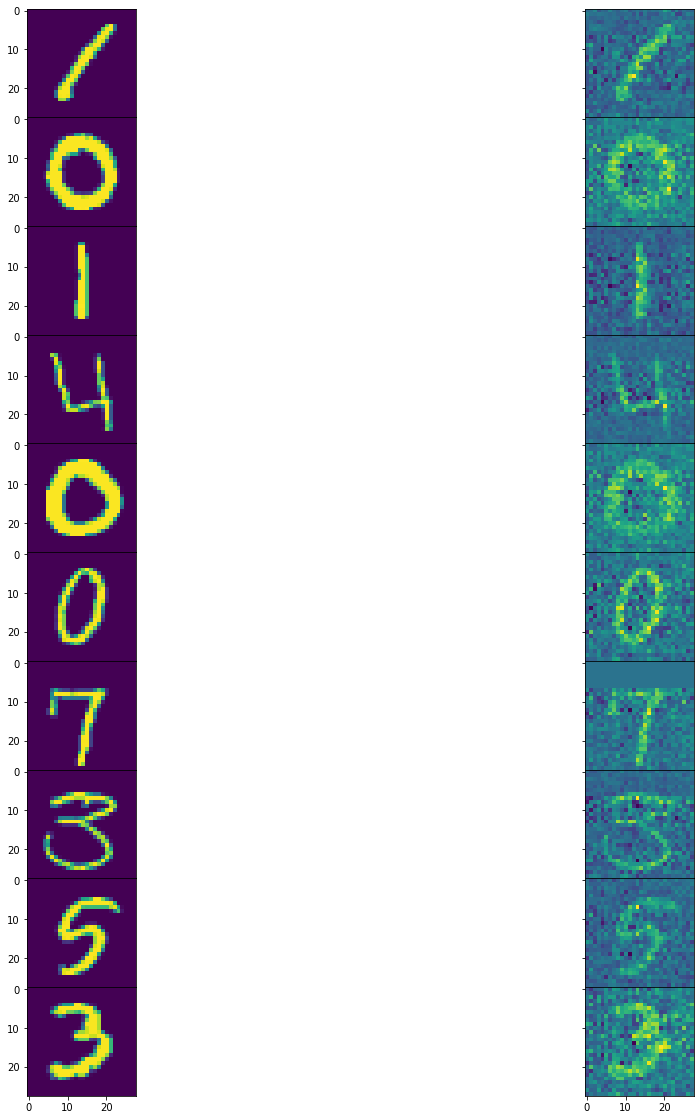

In [20]:
num_reconstructions = 10
fig = plt.figure(figsize=(20, 20))
gs = fig.add_gridspec(num_reconstructions, 2, hspace=0, wspace=0)
axs = gs.subplots(sharex='col', sharey='row')
for i in range(num_reconstructions):
    axs[i][0].imshow(X.values[i].reshape([28, 28]))
    reconstructions = sparse_model.forward(torch.from_numpy(X.values[i].reshape([-1, dict_filter_size])))
    axs[i][1].imshow(reconstructions.reshape([28, 28]).cpu())
plt.show()